# Energy-dependent third-factor STDP

### Idea
<img src=img/3f-stdp.png width="300" />

Based on [*Wyatt et al., 2010: Metabolic Regulation of Neuronal Plasticity by the Energy Sensor AMPK*](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0008996)
<img src=img/wyatt_fig3.png width="600" />
#### TODO
- [] Read references
    + [] Guetig et al. (2003). Learning input correlations through nonlinear temporally asymmetric hebbian plasticity. Journal of Neuroscience, 23:3697-3714 DOI: https://doi.org/10.1523/JNEUROSCI.23-09-03697.2003
    + [X] **Rubin J, Lee D, Sompolinsky H (2001). Equilibrium properties of temporally asymmetric Hebbian plasticity. Physical Review Letters**, 86:364-367. DOI: https://doi.org/10.1103/PhysRevLett.86.364
    + [] Song S, Miller KD, Abbott LF (2000). Competitive Hebbian learning through spike-timing-dependent synaptic plasticity. Nature Neuroscience 3(9):919-926. DOI: https://doi.org/10.1038/78829
    + [] van Rossum MCW, Bi G-Q, Turrigiano GG (2000). Stable Hebbian learning from spike timing-dependent plasticity. Journal of Neuroscience, 20(23):8812-8821. DOI: https://doi.org/10.1523/JNEUROSCI.20-23-08812.2000

- NestML ReadTheDocs: [modeling synapses](https://nestml.readthedocs.io/en/v5.0.0/nestml_language/synapses_in_nestml.html)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import re
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Preliminaries

Experiments have shown that synaptic strength changes as a function of the precise spike timing of the presynaptic and postsynaptic neurons. If the pre neuron fires an action potential strictly before the post neuron, the synapse connecting them will be strengthened (“facilitated”). If the pre neuron fires after the post neuron, the synapse will be weakened (“depressed”). The depression and facilitation effects become stronger when the spikes occurred closer together in time. This is illustrated by empirical results (open circles), fitted by exponential curves (solid lines).


<div>
<img src="img\bi&poo.png" width="500">
</div>

*Asymmetric STDP learning window. Spike-timing window of STDP for the induction of synaptic potentiation and depression characterized in hippocampal cultures. Data points from Bi and Poo (1998) [18], represent the relative change in the amplitude of EPSC after repetitive correlated activity of pre-post spike pairs. The LTP (+) and LTD (-) windows are fitted by the exponential function ∆g = A ± exp(−|∆t|/τ), with parameters A + = 0.86, A − = −0.25, τ + = 19 ms, and τ − = 34 ms. Adopted from Bi and Wang (2002).*

We will define the theoretical model following:
Rubin, Lee and Sompolinsky. Equilibrium Properties of Temporally Asymmetric Hebbian Plasticity. Physical Review Letters, 8 Jan 2001, Vol 86, No 2 http://doi.org/10.1103/PhysRevLett.86.364

A pair of spikes in the input and the output cell, at times $t_i$ and $t_j$ respectively, induces a change $\Delta w$ in the weight $w$:

\begin{equation}
\Delta^\pm w = \pm \lambda \cdot f_\pm(w) \cdot K(|t_o - t_i|)
\end{equation}

The weight is increased by $\Delta^+ w$ when $t_o>t_i$ and decreased by $\Delta^- w$ when $t_i>t_o$. The temporal dependence of the update is defined by the filter kernel $K$ which is taken to be $K(t) = \exp(-t/\tau)$. The coefficient $\lambda\in\mathbb{R}$ sets the magnitude of the update. The functions $f_\pm(w)$ determine the relative magnitude of the changes in the positive and negative direction. These are here taken as

\begin{align}
f_+(w) &= (1 - w)^{\mu_+}\\
f_-(w) &= \alpha w^{\mu_-}
\end{align}

with the parameter $\alpha\in\mathbb{R}, \alpha>0$ allowing to set an asymmetry between increasing and decreasing the synaptic efficacy, and $\mu_\pm\in\{0,1\}$ allowing to choose between four different kinds of STDP (for references, see https://nest-simulator.readthedocs.io/en/v2.18.0/models/stdp.html#_CPPv4I0EN4nest14STDPConnectionE).

To implement the kernel, we use two extra state variables to keep track of recent spiking activity. These could correspond to calcium concentration in biology. One presynaptic trace value and another postsynaptic trace value is used, for pre- and post spiking, respectively. These maintain a history of neuron spikes, being incremented by 1 whenever a spike is generated, and decaying back to zero exponentially; in other words, a convolution between the exponentially decaying kernel and the emitted spike train:

\begin{equation}
\text{tr_pre} = K \ast \sum_i \delta_{pre,i}
\end{equation}

and

\begin{equation}
\text{tr_post} = K \ast \sum_i \delta_{post,i}
\end{equation}

These are implemented in the NESTML model as follows:

```
  equations:
    # all-to-all trace of presynaptic neuron
    kernel pre_tr_kernel = exp(-t / tau_tr_pre)
    inline pre_tr real = convolve(pre_tr_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_tr_kernel = exp(-t / tau_tr_post)
    inline post_tr real = convolve(post_tr_kernel, post_spikes)
end
```

with time constants defined as parameters:

```
   parameters:
     tau_tr_pre ms = 20 ms
     tau_tr_post ms = 20 ms
   end
```

With the traces in place, the weight updates can then be expressed closely following the mathematical definitions.

Begin by defining the weight and its initial value:

```
   state:
     w real = 1.
   end
```

The update rule for facilitation:

\begin{equation}
\Delta^+ w = \lambda \cdot (1 - w)^{\mu+} \cdot \text{pre_trace}
\end{equation}

In NESTML, this rule is written in the `onReceive` event handler block. Statements in this block will be executed when the event occurs: in this case, receiving a presynaptic spike. In NESTML, additional scaling with an absolute maximum weight ``Wmax`` is added.

```
   onReceive(post_spikes):
     # potentiate synapse
     w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
     w = min(Wmax, w_)
   end
```

The update rule for depression :

\begin{equation}
\Delta^- w = -\alpha \cdot \lambda \cdot w^{\mu_-} \cdot \text{post_trace}
\end{equation}

```
   onReceive(pre_spikes):
     # depress synapse
     w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
     w = max(Wmin, w_)

     # deliver spike to postsynaptic partner
     deliver_spike(w, d)
   end
```

Finally, the remaining parameters are defined:

```
   parameters:
     lambda real = .01
     alpha real = 1.
     mu_plus real = 1.
     mu_minus real = 1.
     Wmax real = 100.
     Wmin real = 0.
   end
```


## Simple simulations

No NEST nor NESTML needed here

In [16]:
## Standar STDP Rules parameters
tau_up = 20
tau_down = 20
lam = 0.005
alpha = 0.5 # 0.95
mu_p = 0.0
mu_m = 0.0
w_max = 100
w_min = 0
w_init = 1

## sim parameters
stim_time_n = 200 # number of time "samples"
init_time = 100 # max spike-time difference: t_o - t_i
end_time = 1 # min spike-time difference: t_o - t_i
delta_t_neg = np.linspace(-init_time,-end_time, int(stim_time_n/2))
delta_t_pos = np.linspace(end_time, init_time, int(stim_time_n/2))
delta_t = np.append(delta_t_neg, delta_t_pos)
stim_time= 1000 # ms
pre_spikes_per_sim = 2 # how many times do we want post and pre synaptic neuron to fire?

In [17]:
def delta_w(lam, mu_p, mu_m, alpha, 
            delta_t, w, tau_up, tau_down, w_max):
    """
    computes delta w
    """
    # delta_t = t_o - t_i
    min_delta_t = 0 # ms
    if abs(delta_t) <= min_delta_t:
        if w >= 0:
            d_w = -w # so w = w + d_w => w = 0
    elif delta_t > min_delta_t:
        # facilitation
        #d_w = lam*(1-w)**mu_p*np.exp(-abs(delta_t)/tau_up)
        d_w = lam * (1-(w/w_max)) ** mu_p * np.exp(-abs(delta_t) / tau_up)
        d_w *= w_max # rescale 
    elif delta_t < min_delta_t:
        # depression
        #d_w = -alpha*lam*(w)**mu_m*np.exp(-abs(delta_t)/tau_down)
        d_w = -alpha * lam * (w/w_max) ** mu_m * np.exp(-abs(delta_t) / tau_down)
        d_w *= w_max # rescale accounting w_max
    return d_w

In [23]:
#delta_t = t_o - t_i
# obtain delta w for classical stdp rule (no energy dependencies)
w_all = []
d_w_tot = []
verbose = False
for k, d_t in enumerate(delta_t):
    for n in range(pre_spikes_per_sim): #range(int(abs(stim_time/d_t))):
        if n == 0:
            w = w_init
            if k%10 == 0 and verbose:
                print(f"iter: {k}, delta_d: {d_t}, w_init: {w}")
        else:
            w += delta_w(lam, mu_p, mu_m, alpha, 
                         d_t, w, tau_up, tau_down, w_max)
            #w = max(min(w_max, w), w_min)
        if n == pre_spikes_per_sim-1: #int(abs(stim_time/d_t)) - 1:
            d_w_tot.append((w - w_init)/lam)
    if k%10 == 0 and verbose:
        print(f"iter: {k}, delta_d: {d_t}, w_end: {w}, d_w_tot: {d_w_tot[-1]}")
    w_all.append(w)

## simple extension

\begin{equation}
\Delta^\pm w = \pm \lambda(A) \cdot f_\pm(w) \cdot K(|t_o - t_i|)
\end{equation}

Where:
\begin{equation}
\lambda(A) := \lambda f(A) \quad \textit{for $\Delta^+ w$}, 
\end{equation}
and
\begin{equation}
\lambda(A) = \lambda \quad \textit{otherwise}, 
\end{equation}

So ATP level is onl affecting potentiation (LTP).

In principle, for $f(A)$, we suggest:
\begin{equation}
f(A) = (A/100)^2,
\end{equation}
but we can use other functions as well. Here we are assuming the ATP is in percent: $A \in [0, 100]$

In [19]:
#delta_t = t_o - t_i
verbose = False
def stdp_ATP(ATP = 100,
            delta_t = delta_t, 
            pre_spikes_per_sim = pre_spikes_per_sim,
            w_init = w_init,
            lam = lam,
            mu_p = mu_p,
            mu_m = mu_m,
            alpha = alpha,
            tau_up = tau_up,
            tau_down = tau_down,
            verbose = verbose
            ):
    w_all_ed = []    # list with all final w values
    d_w_tot_ed = []  # total delta w list
    for k, d_t in enumerate(delta_t):
        for n in range(pre_spikes_per_sim): #range(int(abs(stim_time/d_t))):
            if n == 0:
                w = w_init
                e_term = (ATP/100)**2
                #exponent = (1.-ATP/100)**10
                exponent = (1.-e_term)
                e_term_exp = np.exp(-exponent) 
                energy_term = e_term # e_term or e_term_exp
                if k%10 == 0 and verbose:
                    print(f"iter: {k}, delta_d: {d_t}, w_init: {w}")
            else:
                if d_t > 0:
                    w += delta_w(lam*energy_term, mu_p, mu_m, alpha, 
                                 d_t, w, tau_up, tau_down, w_max)
                else:
                    w += delta_w(lam, mu_p, mu_m, alpha, 
                                 d_t, w, tau_up, tau_down, w_max)
                #w = max(min(w_max, w), w_min)
            if n == pre_spikes_per_sim -1: # int(abs(stim_time/d_t)) - 1:
                d_w_tot_ed.append((w - w_init)/lam)
        if k%10 == 0 and verbose:
            print(f"iter: {k}, delta_d: {d_t}, w_end: {w}, d_w_tot: {d_w_tot[-1]}")
            print(f"e_term_exp = {e_term_exp}")
            print(f"e_term = {e_term}")
            print(f"exponent = {exponent}")
        w_all_ed.append(w)
    return w_all_ed, d_w_tot_ed

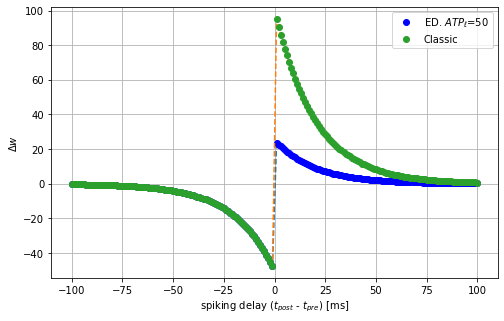

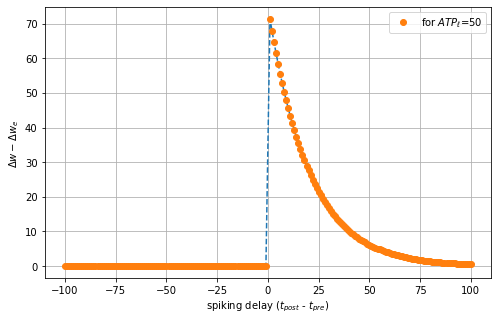

In [20]:
plt.figure(figsize=(8, 5))
# ed stdp
ATP_LEVEL = 50
w_all_ed, d_w_tot_ed = stdp_ATP(ATP=ATP_LEVEL, verbose=False)
plt.plot(delta_t, d_w_tot_ed, "--")
plt.plot(delta_t, d_w_tot_ed, "ob", label=f"ED. $ATP_\ell$={ATP_LEVEL}")
# classic atp
plt.plot(delta_t, d_w_tot, "--")
plt.plot(delta_t, d_w_tot, "o", label="Classic")
plt.xlabel("spiking delay ($t_{post}$ - $t_{pre}$) [ms]")
plt.ylabel(r"$\Delta w$ ")
plt.legend()
plt.grid()

# classic stdp - ed_stdp
diff = [] # classic stdp - ed stdp
for n, ele in enumerate(d_w_tot):
    diff.append(d_w_tot[n] - d_w_tot_ed[n])

plt.figure(figsize=(8, 5))
plt.plot(delta_t, diff, "--")
plt.plot(delta_t, diff, "o", label=f"for $ATP_\ell$={ATP_LEVEL}")
plt.xlabel("spiking delay ($t_{post}$ - $t_{pre}$)")
plt.ylabel(r"$\Delta w - \Delta w_{e}$ ")
plt.legend()
plt.grid()

 ATP array: [100.  90.  80.  70.  60.  50.  40.  30.  20.  10.   0.]


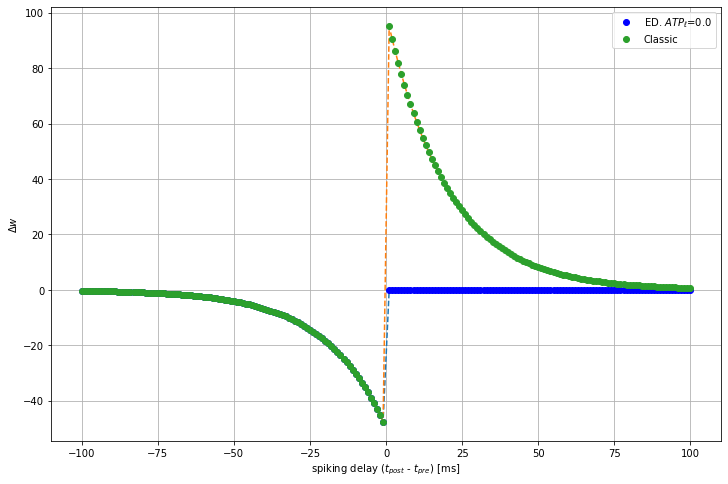

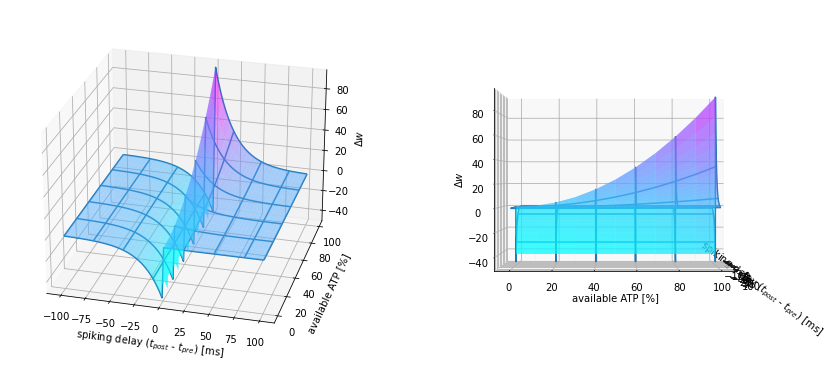

In [21]:
atp_samples = 11
atp_array = np.linspace(100, 0, num=atp_samples)
print(f" ATP array: {atp_array}")
w_3d_ed, d_w_3d_ed = [], []
for atp in atp_array:
    w_all_ed, d_w_tot_ed = stdp_ATP(ATP=atp)
    w_3d_ed.append(w_all_ed)
    d_w_3d_ed.append(d_w_tot_ed)

plt.figure(figsize=(12, 8))
# ed stdp
plt.plot(delta_t, d_w_tot_ed, "--")
plt.plot(delta_t, d_w_tot_ed, "ob", label=f"ED. $ATP_\ell$={atp}")
# classic atp
plt.plot(delta_t, d_w_tot, "--")
plt.plot(delta_t, d_w_tot, "o", label="Classic")
plt.xlabel("spiking delay ($t_{post}$ - $t_{pre}$) [ms]")
plt.ylabel(r"$\Delta w$ ")
plt.legend()
plt.grid()


# 3d plot
x = delta_t
y = atp_array
X, Y = np.meshgrid(x, y)
Z = d_w_3d_ed

import matplotlib.cm as cmp 

"""
# color
import matplotlib.cm as cmp 
colormap = cmp.cool

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary') # contour
ax.scatter(X, Y, Z, marker="o", cmap='binary') # scatter
ax.plot_surface(X, Y, np.array(Z), 
                cmap=cmp.cool,
                alpha=0.5)
ax.set_xlabel('spiking delay ($t_{post}$ - $t_{pre}$) [ms]')
ax.set_ylabel('available ATP [%]')
ax.set_zlabel(r"$\Delta w$ ")
ele = 0
azm = -90 
ax.view_init(elev=ele, azim=azm)
"""
n_col = 2
ele_list = [25, 0]
azm_list = [-75, 0*20]
#fig, axes = plt.subplots(1, n_col)
fig = plt.figure(figsize=(14, 7))#figsize=plt.figaspect(0.5))
for col in range(n_col):
    ax = fig.add_subplot(1, 2, col + 1, projection='3d')
    #ax.scatter(X, Y, Z, 
    #           marker="o", 
    #           cmap=cmp.cool,
    #           alpha=0.1) # scatter
    #ax.contour3D(X, Y, Z, cmap=cmp.cool) # contour 
    ax.plot_wireframe(X, Y, np.array(Z),
                      cmap=cmp.cool,
                      rstride=2, 
                      cstride=30)
    ax.plot_surface(X, Y, np.array(Z), 
                    cmap=cmp.cool,
                    alpha=0.5)
    ax.set_xlabel('spiking delay ($t_{post}$ - $t_{pre}$) [ms]')
    ax.set_ylabel('available ATP [%]')
    ax.set_zlabel(r"$\Delta w$ ")
    ele = ele_list[col]
    azm = azm_list[col]
    ax.view_init(elev=ele, azim=azm)

## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential. Let's download the model from the NESTML repository so it becomes available locally:

In [8]:
import urllib.request 
if not os.path.isdir("models"):
    os.makedirs("models")
if not os.path.isdir("models/neurons"):
    os.makedirs("models/neurons")
if not os.path.isdir("models/synapses"):
    os.makedirs("models/synapses")
urllib.request.urlretrieve("https://raw.githubusercontent.com/nest/nestml/master/models/neurons/iaf_psc_delta.nestml",
                           "models/neurons/iaf_psc_delta.nestml")

('models/neurons/iaf_psc_delta.nestml',
 <http.client.HTTPMessage at 0x7f38a070a260>)

We now define a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. The resulting model names are composed of associated neuron and synapse partners, because of the co-generation, for example, "stdp_synapse__with_iaf_psc_delta" and "iaf_psc_delta__with_stdp_synapse".

Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "stdp_synapse0__with_iaf_psc_delta0" and "iaf_psc_delta0__with_stdp_synapse0".

The resulting neuron and synapse model names are returned by the function, so we do not have to think about these internals.

In [9]:
n_modules_generated = 0
neuron_options = ["edlif_percent_mwe", # 0
                  "edlif_psc_alpha_percent", # 1
                  "iaf_psc_delta", # 2
                  "iaf_psc_alpha", # 3
                  "edlif_psc_exp_percent"] # 4

neuron_idx = 1
neuron_model = neuron_options[neuron_idx]

def generate_code_for(nestml_synapse_model: str):
    """Generate code for a given synapse model, passed as a string, in combination with
    the edlif_psc_percent model.
    
    NEST cannot yet reload modules. Workaround using counter to generate unique names."""
    global n_modules_generated
   
    # append digit to the neuron model name and neuron model filename
    with open("models/neurons/" + neuron_model + ".nestml", "r") as nestml_model_file_orig:
        nestml_neuron_model = nestml_model_file_orig.read()
        nestml_neuron_model = re.sub("neuron\ [^:\s]*:",
                                     "neuron " + neuron_model + str(n_modules_generated) + ":", nestml_neuron_model)
        with open("models/neurons/" + neuron_model + str(n_modules_generated) + ".nestml", "w") as nestml_model_file_mod:
            print(nestml_neuron_model, file=nestml_model_file_mod)

    # append digit to the synapse model name and synapse model filename
    nestml_synapse_model_name = re.findall("synapse\ [^:\s]*:", nestml_synapse_model)[0][8:-1]
    nestml_synapse_model = re.sub("synapse\ [^:\s]*:",
                                  "synapse " + nestml_synapse_model_name + str(n_modules_generated) + ":", nestml_synapse_model)
    with open("models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml", "w") as nestml_model_file:
        print(nestml_synapse_model, file=nestml_model_file)

    # generate the code for neuron and synapse (co-generated)
    module_name = "nestml_" + str(n_modules_generated) + "_module"
    generate_nest_target(input_path=["models/neurons/"+ neuron_model + str(n_modules_generated) + ".nestml",
                                     "models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml"],
                         target_path="/tmp/nestml_module",
                         logging_level="ERROR",
                         module_name=module_name,
                         suffix="_nestml",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION,
                                       "neuron_parent_class": "StructuralPlasticityNode",
                                       "neuron_parent_class_include": "structural_plasticity_node.h",
                                       "neuron_synapse_pairs": [{"neuron": neuron_model + str(n_modules_generated),
                                                                   "synapse": nestml_synapse_model_name + str(n_modules_generated),
                                                                   "post_ports": ["post_spikes",
                                                                                 ["post_ATP", "ATP"]]}]})
    
    # load module into NEST
    nest.ResetKernel()
    nest.Install(module_name)

    mangled_neuron_name = neuron_model + str(n_modules_generated) + "_nestml__with_" + nestml_synapse_model_name + str(n_modules_generated) + "_nestml"
    mangled_synapse_name = nestml_synapse_model_name + str(n_modules_generated) + "_nestml__with_" + neuron_model + str(n_modules_generated) + "_nestml"

    n_modules_generated += 1
    
    print("mangled_neuron_name")
    print(mangled_neuron_name)
    print("mangled_synapse_name")
    print(mangled_synapse_name)
    
    return mangled_neuron_name, mangled_synapse_name

In [10]:
nestml_stdp_model = """
synapse ed_stdp:

state:
    w real = 1
end

parameters:
    d ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lambda real = .01
    tau_tr_pre ms = 20 ms
    tau_tr_post ms = 20 ms
    alpha real = 1
    mu_plus real = 0
    mu_minus real = 0
    Wmax real = 100.
    Wmin real = 0.
end

equations:
    kernel pre_trace_kernel = exp(-t / tau_tr_pre)
    inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_trace_kernel = exp(-t / tau_tr_post)
    inline post_trace real = convolve(post_trace_kernel, post_spikes)
end

input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
    post_ATP real <- continuous
end

output: spike

onReceive(post_spikes):
    # potentiate synapse
    ATP real = post_ATP/100
    energy_factor_ real = (post_ATP/100)**2
    # exp((1 - post_ATP/100)**2/sigma_e)
    w_ real = Wmax * (w / Wmax + (energy_factor_ * lambda * (1.0 - (w / Wmax)) ** mu_plus * pre_trace))
    w = min(Wmax, w_)
end

onReceive(pre_spikes):
    # depress synapse
    # no energy-dependence fro drepress synapses yet
    energy_factor_ real = 1 # post_ATP/100
    w_ real = Wmax * (w / Wmax - (energy_factor_ * alpha * lambda * (w / Wmax) ** mu_minus * post_trace))
    w = max(Wmin, w_)

    # deliver spike to postsynaptic partner
    deliver_spike(w, d)
end


end
"""

In [11]:
neuron_model_name, synapse_model_name = generate_code_for(nestml_stdp_model)



Marking post_spikes__for_ed_stdp0_nestml as post port
Marking post_spikes__for_ed_stdp0_nestml as post port
-- The CXX compiler identification is GNU 9.4.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_0_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : -fvisibility-inlines-hidden -std=c++17 -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/wis/anaconda3/envs/wnestml/include
NEST compiler flags  :  -O2 -std=c++11 -Wall -fopenmp -fdiagnostics-color=auto
NEST include dirs    :  -I/home/wis/anaconda

/tmp/nestml_module/ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml.h: In instantiation of ‘void nest::ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml<targetidentifierT>::send(nest::Event&, nest::thread, const nest::ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestmlCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierIndex; nest::thread = int]’:
/home/wis/anaconda3/envs/wnestml/include/nest/connector_base.h:379:7:   required from ‘void nest::Connector<ConnectionT>::send_to_all(nest::thread, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml<nest::TargetIdentifierIndex>; nest::thread = int]’
/home/wis/anaconda3/envs/wnestml/include/nest/connector_base.h:373:3:   required from here
/tmp/nestml_module/ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml.h:564:22: warning: unused variable ‘_tr_t’ [-Wunused-variable]
  564 |         const double _tr_t = start->t_;
      

/tmp/nestml_module/ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml.h: In instantiation of ‘void nest::ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml<targetidentifierT>::send(nest::Event&, nest::thread, const nest::ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestmlCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierIndex; nest::thread = int]’:
/home/wis/anaconda3/envs/wnestml/include/nest/connector_base.h:379:7:   required from ‘void nest::Connector<ConnectionT>::send_to_all(nest::thread, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml<nest::TargetIdentifierIndex>; nest::thread = int]’
/home/wis/anaconda3/envs/wnestml/include/nest/connector_base.h:373:3:   required from here
/tmp/nestml_module/ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml.h:564:22: warning: unused variable ‘_tr_t’ [-Wunused-variable]
  564 |         const double _tr_t = start->t_;
      

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [93]:
def run_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=1., # [ms]
                          lmbda=1E-6,
                          sim_time=None,  # if None, computed from pre and post spike times
                          synapse_parameters=None,  # optional dictionary passed to the synapse
                          fname_snip=""):

    nest.set_verbosity("M_WARNING")
    #nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    wr = nest.Create('weight_recorder')
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                {"weight_recorder": wr[0],
                 "w": 1.,
                 "delay": delay,
                 "d": delay,
                 "receptor_type": 0})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time, sim_time - 10.]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time],
                                  'allow_offgrid_times': True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 1599.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    if synapse_parameters is None:
        synapse_parameters = {}
    synapse_parameters.update({"lambda": lmbda})
    nest.SetStatus(syn, synapse_parameters)

    initial_weight = nest.GetStatus(syn)[0]["w"]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0]["w"]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    dt = actual_t_post_sp - actual_t_pre_sp
    dw = (updated_weight - initial_weight) / lmbda
    
    print("prespike time")
    print(nest.GetStatus(spikedet_pre)[0]["events"]["times"])
    print("prespike senders")
    print(nest.GetStatus(spikedet_pre)[0]["events"]["senders"])
    print("postspike time")
    print(nest.GetStatus(spikedet_post)[0]["events"]["times"])
    print("postspike senders")
    print(nest.GetStatus(spikedet_post)[0]["events"]["senders"])
    print("initial weight")
    print(initial_weight)
    print("updated weight")
    print(updated_weight)
    
    return dt, dw

Then, we can run the experiment. We set the pre spike time to a constant (100 ms) and loop over values for the post spike time (25 to 175 ms).

Note that the dendritic delay in this example has been set to 10 ms, to make its effect on the STDP window more clear: it is not centered around zero, but shifted to the left by the dendritic delay. Hint: play with the parameters a bit here and see the effects it has on the returned window.

In [94]:
def stdp_window(neuron_model_name, synapse_model_name, synapse_parameters=None):
    sim_time = 1000.  # [ms]
    pre_spike_time = 100. #sim_time / 2  # [ms]
    delay = 10. # dendritic delay [ms]

    dt_vec = []
    dw_vec = []
    for post_spike_time in np.arange(25, 175).astype(float):
        dt, dw = run_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=delay, # [ms]
                          synapse_parameters=synapse_parameters,
                          sim_time=sim_time)
        dt_vec.append(dt)
        dw_vec.append(dw)
        
    return dt_vec, dw_vec, delay

# OBS: using this window, we only have one spike for post and pre sytnaptic neurons

In [95]:
def plot_stdp_window(dt_vec, dw_vec, delay):
    fig, ax = plt.subplots(dpi=120)
    ax.scatter(dt_vec, dw_vec)
    ax.set_xlabel(r"t_post - t_pre [ms]")
    ax.set_ylabel(r"$\Delta w$")

    for _ax in [ax]:
        _ax.grid(which="major", axis="both")
        _ax.grid(which="minor", axis="x", linestyle=":", alpha=.4)
        _ax.set_xlim(np.amin(dt_vec), np.amax(dt_vec))
        #_ax.minorticks_on()
        #_ax.set_xlim(0., sim_time)

    ylim = ax.get_ylim()
    ax.plot((np.amin(dt_vec), np.amax(dt_vec)), (0, 0), linestyle="--", color="black", linewidth=2, alpha=.5)
    ax.plot((-delay, -delay), ylim, linestyle="--", color="black", linewidth=2, alpha=.5)
    ax.set_ylim(ylim)

prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[30.]
postspike senders
[5]
initial weight
1.0
updated weight
0.9999976320537806
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[31.]
postspike senders
[5]
initial weight
1.0
updated weight
0.9999975106465817
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[32.]
postspike senders
[5]
initial weight
1.0
updated weight
0.9999973830147026
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[33.]
postspike senders
[5]
initial weight
1.0
updated weight
0.9999972488389972
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[34.]
postspike senders
[5]
initial weight
1.0
updated weight
0.9999971077839562
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[35.]
postspike senders
[5]
initial weight
1.0
updated weight
0.9999969594968688
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[36.]
postspike senders
[5]
initial weight
1.0
updated weight
0.99

prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[93.]
postspike senders
[5]
initial weight
1.0
updated weight
1.000090483741795
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[94.]
postspike senders
[5]
initial weight
1.0
updated weight
1.000086070797634
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[95.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000818730752996
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[96.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000778800782992
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[97.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000740818220606
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[98.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000704688089643
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[99.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000

prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[150.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000052339705932
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[151.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000049787068355
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[152.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000047358924375
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[153.]
postspike senders
[5]
initial weight
1.0
updated weight
1.000004504920238
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[154.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000042852126854
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[155.]
postspike senders
[5]
initial weight
1.0
updated weight
1.0000040762203966
prespike time
[101. 991.]
prespike senders
[4 4]
postspike time
[156.]
postspike senders
[5]
initial weight
1.0
updated weigh

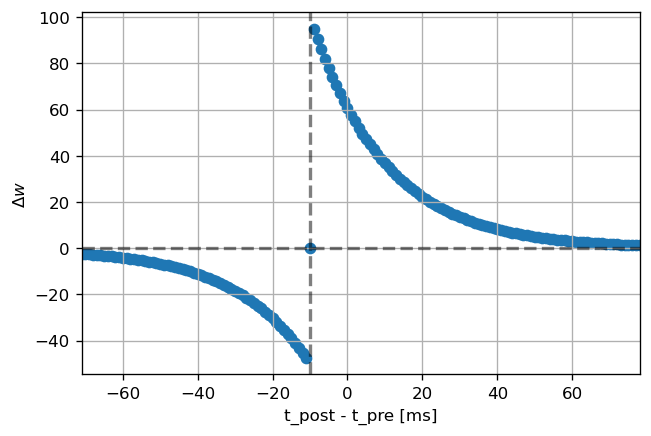

In [96]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name,
                                    synapse_parameters={"alpha": .5,
                                                       #"lambda": 0.005,
                                                       "mu_plus": 0,
                                                       "mu_minus": 0
                                                       })

plot_stdp_window(dt_vec, dw_vec, delay)